## Sagnac Frequency - Backscatter Correction - Optinmize CM

Explore CM values

## Imports

In [60]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

In [79]:
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.interpolate_nan import __interpolate_nan
from functions.reduce import __reduce
from functions.load_backscatter_data import __load_backscatter_data
from functions.load_lxx import __load_lxx
from functions.get_lxx_intervals import __get_lxx_intervals


In [62]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

## Configurations

In [148]:
config = {}

config['ring'] = "V"

config['seed'] = f"BW.DROMY..FJ{config['ring']}"

config['path_to_sds'] = archive_path+"romy_archive/"

# after setting up mono beam PDs
# config['tbeg'] = UTCDateTime("2024-05-24 00:00")
# config['tend'] = UTCDateTime("2024-05-28 00:00")
# flim1, flim2 = 447.726, 447.732

# after readjustment
config['tbeg'] = UTCDateTime("2024-07-05 16:00")
config['tend'] = UTCDateTime().now()
flim1, flim2 = 447.731, 447.741

## path to Sagnac data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"

config['path_to_out_data'] = data_path+"sagnac_frequency/data/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"


config['colors'] = {  1:'darkgreen',
                      3:'lightgreen',
                      4:'purple',
                      5:'darkred',
                      6:'darkblue',
                      7:'darkorange',
                      8:'darkcyan',
                      9:'cyan',
                     }

### Load backscatter data

In [149]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

### Cut corrupt data periods

In [150]:
bs['fj_fs'] = np.where((bs.fj_fs > flim2), np.nan, bs.fj_fs)
bs['fj_fs'] = np.where((bs.fj_fs < flim1), np.nan, bs.fj_fs)

### Filter MTLI

In [151]:

mlti = __load_mlti(config['tbeg'], config['tend'], config['ring'], archive_path)

mlti_t1, mlti_t2 = __get_mlti_intervals(mlti.time_utc)

bs = __mlti_intervals_to_NaN(bs, "fj_fs", "time1", mlti_t1, mlti_t2, t_offset_sec=180)


In [152]:
bs['fj_fs_inter'] = __interpolate_nan(np.array(bs.fj_fs_nan))

### Load Maintenance Log

In [153]:
lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)


### Compute Backscatter (again)

In [154]:
from functions.backscatter_correction import __backscatter_correction

In [155]:
from functions.variance_reduction import __variance_reduction

In [156]:
key = "fj_fs_nan"

cms = np.linspace(0.1, 5, 20)
vr = np.zeros(len(cms))

for jj, cm in enumerate(cms):

    # unwrap phases as one time series
    # bs['fj_ph'] = np.unwrap(bs.fj_ph)
    # bs['f1_ph'] = np.unwrap(bs.f1_ph)
    # bs['f2_ph'] = np.unwrap(bs.f2_ph)

    # use complete unwrapped phases
    bs['fj_ph'] = np.unwrap(bs.fj_phw)
    bs['f1_ph'] = np.unwrap(bs.f1_phw)
    bs['f2_ph'] = np.unwrap(bs.f2_phw)

    # fractional beat modulations
    m01 = bs.f1_ac / bs.f1_dc
    m02 = bs.f2_ac / bs.f2_dc

    # phase difference
    ph1 = bs.f1_ph
    ph2 = bs.f2_ph
    phase0 = ph2 - ph1

    # beat signal observed
    w_obs = bs[key]

    # compute backscatter corrected signal
    bs[jj] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs[key]), cm_filter_factor=cm)

    vr[jj] = __variance_reduction(bs[key], bs[jj])

# classic
bs['fj_bs'] = __backscatter_correction(m01, m02, phase0, w_obs, np.median(bs.fj_fs), cm_filter_factor=1.033)
vr_bs = __variance_reduction(bs.fj_fs, bs.fj_bs)


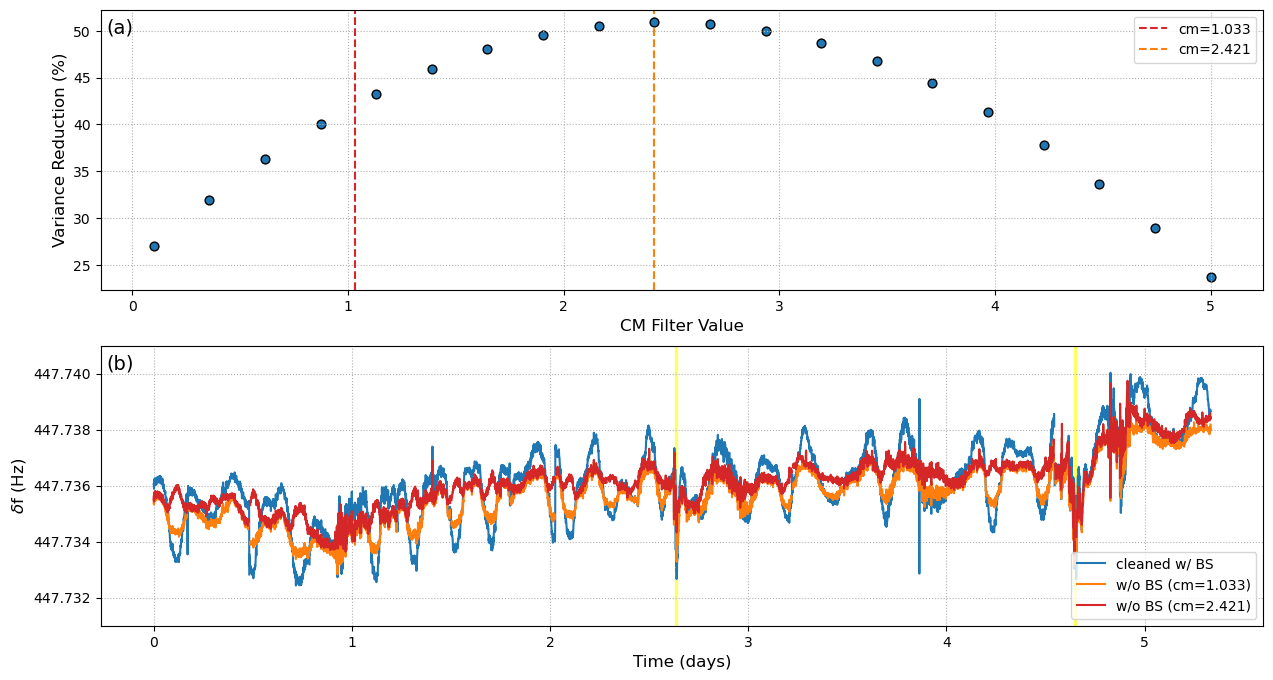

In [158]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    tscale = 1/86400

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8))

    ax[0].scatter(cms, vr, s=40, edgecolor="k")

    ax[0].axvline(1.033, 0, vr_bs, ls="--", color="tab:red",label=f"cm=1.033")
    ax[0].axvline(cms[np.argmax(vr)], 0, np.max(vr), ls="--", color="tab:orange",
                  zorder=0, label=f"cm={round(cms[np.argmax(vr)], 3)}")

    ax[0].set_ylabel("Variance Reduction (%)", fontsize=font)
    ax[0].set_xlabel("CM Filter Value", fontsize=font)

    ax[1].plot(bs.time_sec*tscale, bs.fj_fs, color="tab:blue", alpha=1, label="cleaned w/ BS")
    ax[1].plot(bs.time_sec*tscale, bs.fj_bs, color="tab:orange", alpha=1, label="w/o BS (cm=1.033)")
    ax[1].plot(bs.time_sec*tscale, bs[np.argmax(vr)], color="tab:red", alpha=1, label=f"w/o BS (cm={round(cms[np.argmax(vr)], 3)})")

    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylim(flim1, flim2)
    ax[1].set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax[1].set_xlabel("Time (days)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1)
    ax[1].legend(loc=4)

    ax[0].text(.005, .97, "(a)", ha='left', va='top', transform=ax[0].transAxes, fontsize=font+2)
    ax[1].text(.005, .97, "(b)", ha='left', va='top', transform=ax[1].transAxes, fontsize=font+2)

    # add maintenance periods
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = ( lx1-UTCDateTime(config['tbeg']) )*tscale
        lx2_sec = ( lx2-UTCDateTime(config['tbeg']) )*tscale
        ax[1].fill_betweenx([flim1, flim2], lx1_sec, lx2_sec, color="yellow", alpha=0.5)

    plt.show();
    return fig

fig = __makeplot();

fig.savefig(config['path_to_figs']+f"SF_BS_CMoptimization.png", format="png", dpi=150, bbox_inches='tight')